In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [2]:
from lucy.application.trading.exchange import Exchange
from lucy.model.interval import Interval
from lucy.application.trading.kraken_futures_api import FuturesApi
from lucy.application.trading.chart import chart

In [17]:
pair = "pf_ethusd" #"ETHUSD" #"XBTUSD"
interval = Interval(15)
exch = Exchange()
df_org = exch.ohlc(pair, interval, 'trade')

In [18]:
def chart_title(pair: str, interval: Interval, action: str):
    now = datetime.now().strftime("%y.%m.%d_%H:%M:%S")
    return f"PriceDelta_{pair}_{interval}_{action.upper()}_{now}"

In [13]:
def chart(name: str, dfc: pd.DataFrame, signals_df: list[tuple[str, pd.DataFrame]] = None):  # type: ignore
    signals_df = signals_df or []
    num_signals = len(signals_df)
    top_height = 4
    subplot_height = 2 

    num_rows = num_signals + 2
    height = top_height + (subplot_height * num_signals)
    plt.figure(figsize=(20, height))

    ax1 = plt.subplot2grid((num_rows, 1), (0, 0), rowspan=2)
    ax1.plot(dfc)    
    ax1.legend(dfc.columns)
    ax1.set_title(name)

    i = 2
    for nm, ind in signals_df:
        ax2 = plt.subplot2grid((num_rows, 1), (i, 0), rowspan=1)
        ax2.plot(ind)
        plt.title(nm)
        plt.plot(ind)
        i += 1
    plt.tight_layout()
    plt.show()
    # path = '/mnt/c/lucy_charts/'
    # plt.savefig(f"{path}{name}.png")
    # plt.close()

In [10]:
df = df_org.copy()

strategy = ta.Strategy(
    name="strategy_price_delta",
    ta=[]
)
df.ta.strategy(strategy)
df.tail()

[X] Strategy requires the following argument(s):
 - ta. Format is a list of dicts. Example: [{'kind': 'sma', 'length': 10}]
       Check the indicator for the correct arguments if you receive this error.


,open,high,low,close,volume
time,,,,,
2023-10-04 17:15:00,4.022,4.022,4.022,4.022,0.0
2023-10-04 17:30:00,4.022,4.022,4.021,4.021,18.6
2023-10-04 17:45:00,4.021,4.021,4.021,4.021,0.0
2023-10-04 18:00:00,4.021,4.032,4.021,4.032,4.4
2023-10-04 18:15:00,4.032,4.032,4.032,4.032,0.0


In [33]:
df = df_org.copy()[-2000:]
window = 500
std_dev_level = 2
df['delta'] = df['close'] - df['close'].shift(1)
w = df['delta'].rolling(window=window)
df['std'] = w.std()
df['std_dev_level'] = w.std() * std_dev_level
df['std_dev_level_below'] = -df['std_dev_level']

df['entry_long'] = df.close < df['close'].shift(1) - df['std_dev_level']
df['entry_short'] = df.close > df['close'].shift(1) + df['std_dev_level']

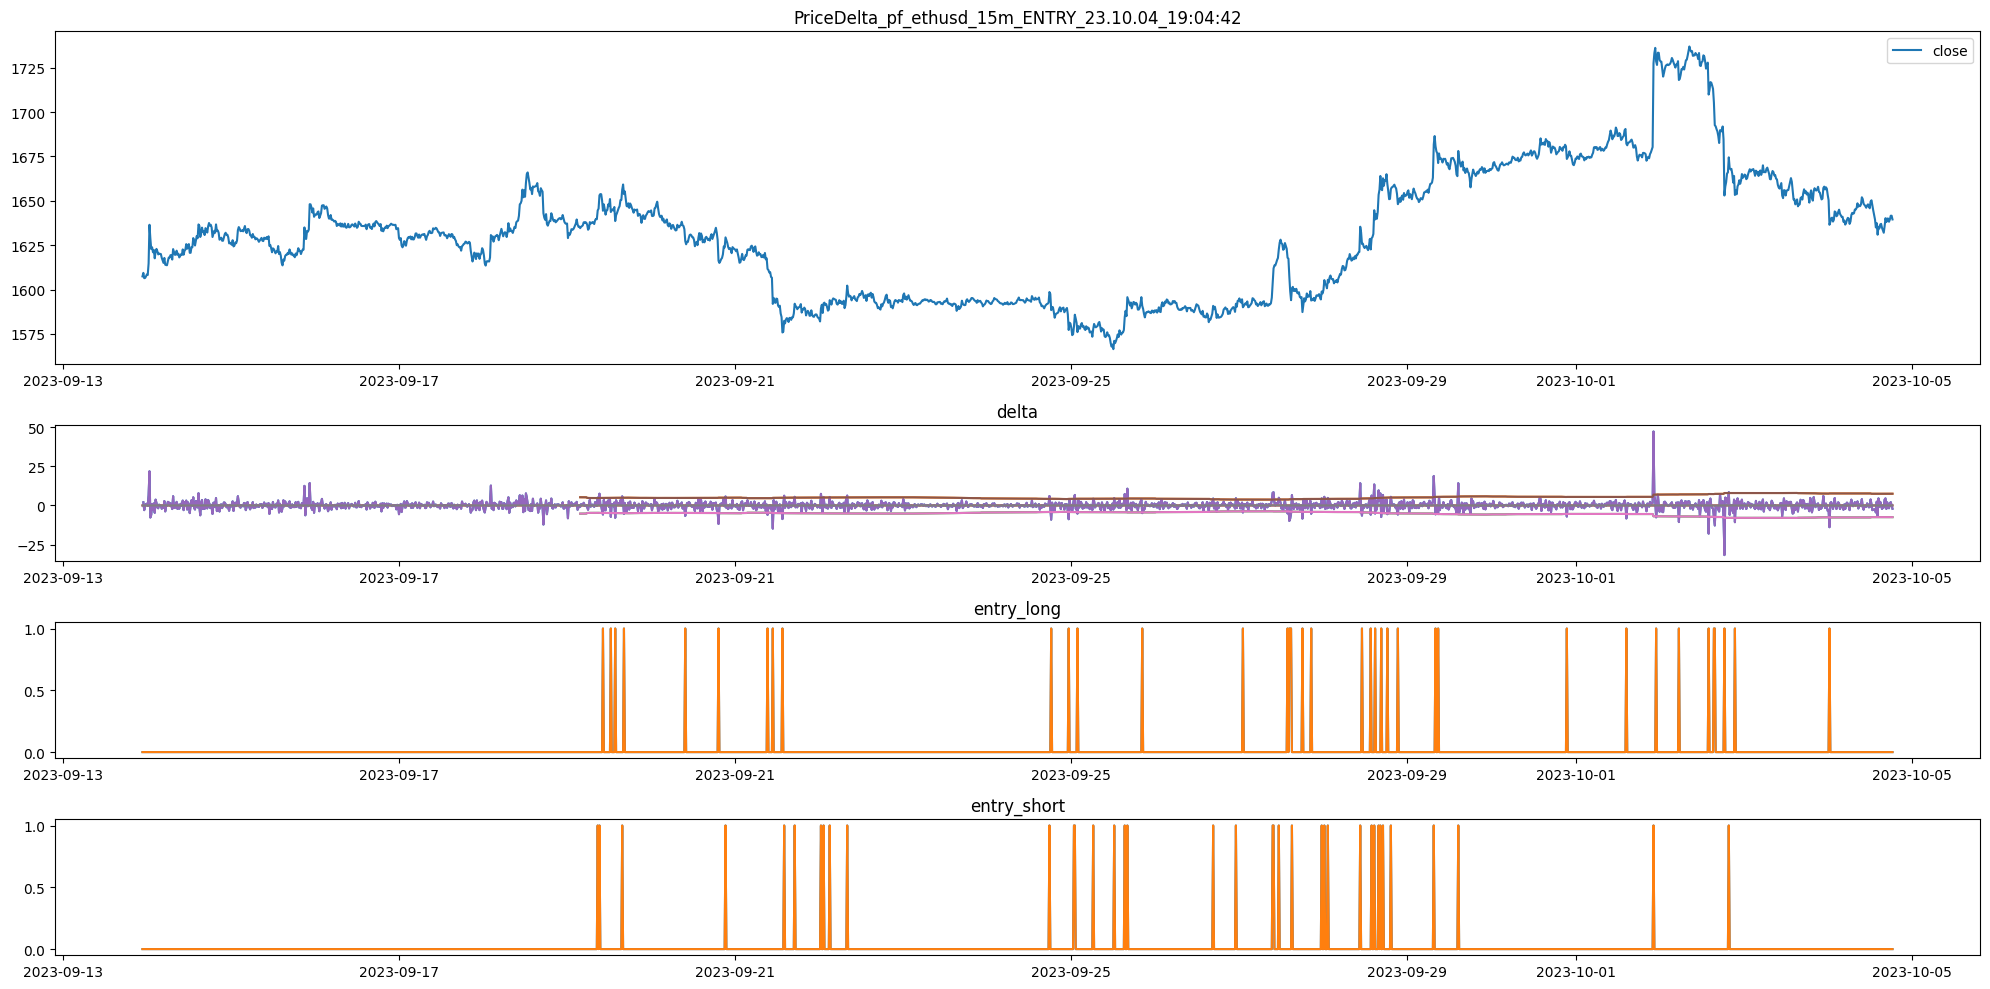

In [34]:
chart_data      = df[['close']]
entry_long   = ('entry_long', df[['entry_long']] )
entry_short   = ('entry_short', df[['entry_short']] )

df['base']      = 0
delta           = ('delta', df[['delta', 'std_dev_level', 'std_dev_level_below', 'base']] )
signals         = [delta, entry_long, entry_short]
name            = chart_title(pair, interval, 'entry')
chart(name, chart_data, signals)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2000 entries, 2023-09-13 22:45:00 to 2023-10-04 18:30:00
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        2000 non-null   float64
 1   high        2000 non-null   float64
 2   low         2000 non-null   float64
 3   close       2000 non-null   float64
 4   volume      2000 non-null   float64
 5   delta       1999 non-null   float64
 6   std         1500 non-null   float64
 7   entry_long  2000 non-null   bool   
 8   stdu        1500 non-null   float64
 9   stdl        1500 non-null   float64
dtypes: bool(1), float64(9)
memory usage: 158.2 KB
